# Year zero handling

The CMIP6 historical concentration data files use a gregorian calendar which has a reference year of zero. There is no year zero in a gregorian calendar so this case cannot be handled by iris. As a result, we provide a simple wrapper to handle this edge case. Note, as we have to read in the entire data file, it can be slow. 

In [1]:
# NBVAL_IGNORE_OUTPUT
import datetime

import iris
import iris.coord_categorisation
import iris.plot as iplt
from netcdf_scm.iris_cube_wrappers import CMIP6Input4MIPsCube

import matplotlib.pyplot as plt
plt.style.use('bmh') 

In [2]:
# NBVAL_IGNORE_OUTPUT
cmip6_hist_concs = CMIP6Input4MIPsCube()
cmip6_hist_concs.load_data_from_identifiers(
    root_dir="../tests/test-data/cmip6input4mips",
    activity_id="input4MIPs",
    mip_era="CMIP6",
    target_mip="CMIP",
    institution_id="UoM",
    source_id="UoM-CMIP-1-2-0",
    realm="atmos",
    frequency="mon",
    variable_id="mole-fraction-of-carbon-dioxide-in-air",
    grid_label="gr1-GMNHSH",
    version="v20100304",
    dataset_category="GHGConcentrations",
    time_range="000001-201412",
    file_ext=".nc",
)

/Users/zebedeenicholls/Documents/AGCEC/Misc/netcdf-scm/src/netcdf_scm/iris_cube_wrappers.py:483: UserWarning: Your calendar is gregorian yet has units of 'days since 0-1-1'. We rectify this by removing all data before year 5 and changing the units to 'days since 1-1-1'. If you want other behaviour, you will need to use another package.
  warnings.warn(warn.message)


In [3]:
cmip6_hist_concs.cube

<iris 'Cube' of mole / (1.e-6) (time: 24120; sector: 3)>

We also make a plot to show how the underlying data looks.

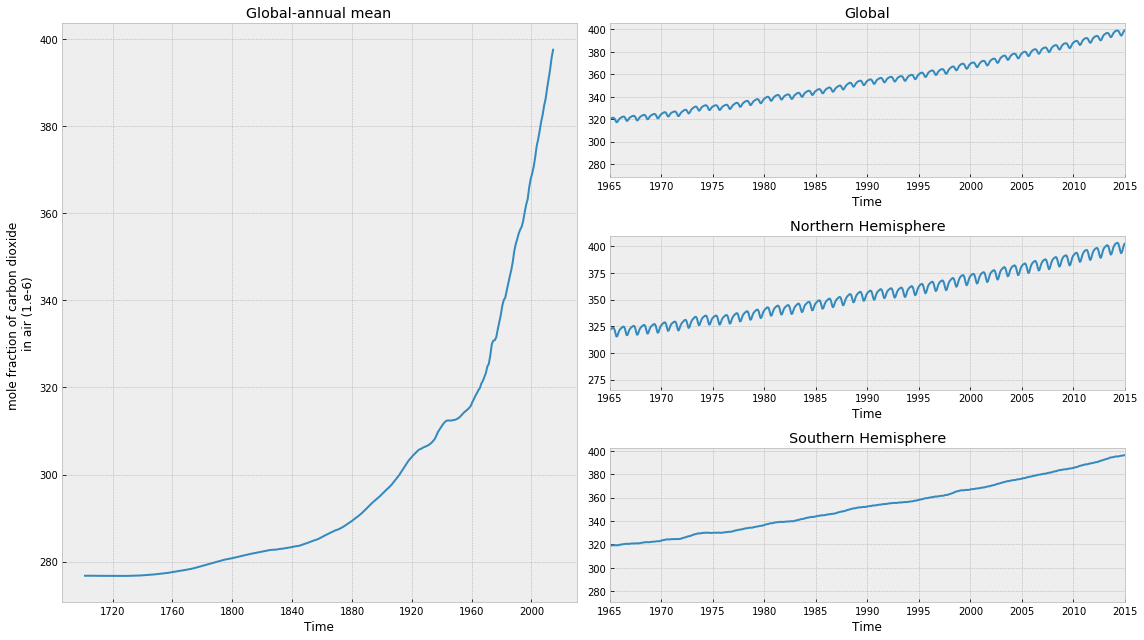

In [4]:
# NBVAL_IGNORE_OUTPUT
yearmin = 1700
cube = cmip6_hist_concs.cube.extract(
    iris.Constraint(time=lambda t: t[0].year > yearmin)
)

fig = plt.figure(figsize=(16, 9))

for i in range(3):
    region = cube.extract(
        iris.Constraint(sector=i)
    )
    for title in region.coord('sector').attributes['ids'].split(";"):
        if title.strip().startswith(str(i)):
            title = title.split(":")[1].strip()
            break

    if "Global" in title:
        plt.subplot(322)
    elif "Northern" in title:
        plt.subplot(324)
    elif "Southern" in title:
        plt.subplot(326)

    iplt.plot(
        region, 
        lw=2.0
    )
    xlabel = "Time"
    plt.title(title)
    plt.xlabel(xlabel)
    plt.xlim([
        datetime.date(1965, 1, 1), 
        datetime.date(2015, 1, 1),
    ])

    if "Global" in title:                
        plt.subplot(121)

        iris.coord_categorisation.add_year(
            region,
            'time', 
            name='year'
        ) 
        region_annual_mean = region.aggregated_by(
            ['year'],
            iris.analysis.MEAN
        )

        iplt.plot(
            region_annual_mean, 
            lw=2.0
        )

        var_name = region.var_name.replace("_", " ")
        var_name = var_name.replace("in", "\nin")
        plt.ylabel("{} ({})".format(var_name, region.units))
        plt.title(title + "-annual mean")
        plt.xlabel("Time")

plt.tight_layout();